In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Install required libraries
!pip install -q scikit-learn imbalanced-learn xgboost

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif


In [57]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')


In [58]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [59]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [60]:
print(df.isnull().sum())
print((df == 'inf').sum())
print((df == -np.inf).sum())

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [61]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

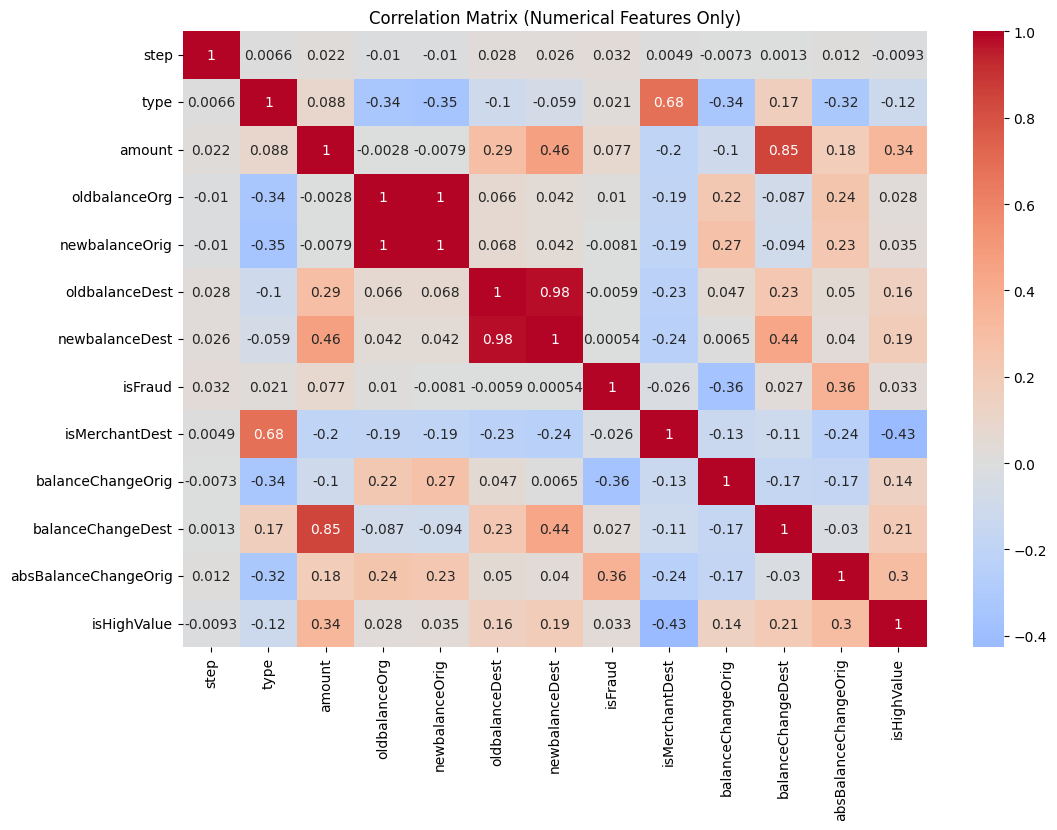

In [ ]:
# For correlation analysis, we'll use only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Numerical Features Only)')
plt.show()

# Remove highly correlated features
df.drop(['newbalanceOrig', 'newbalanceDest'], axis=1, inplace=True)

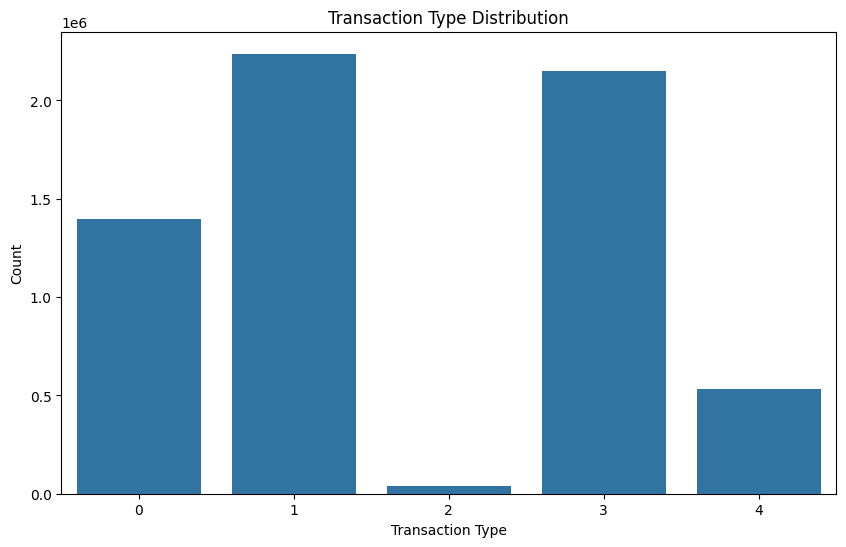

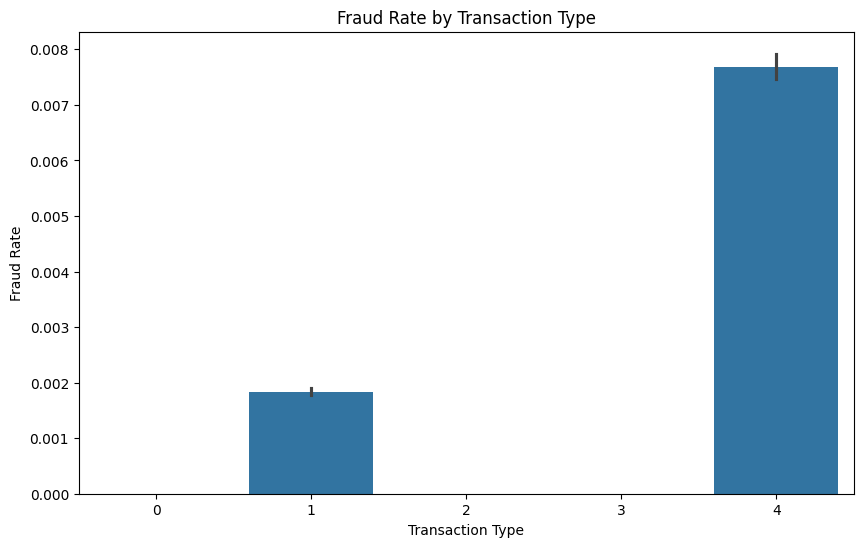

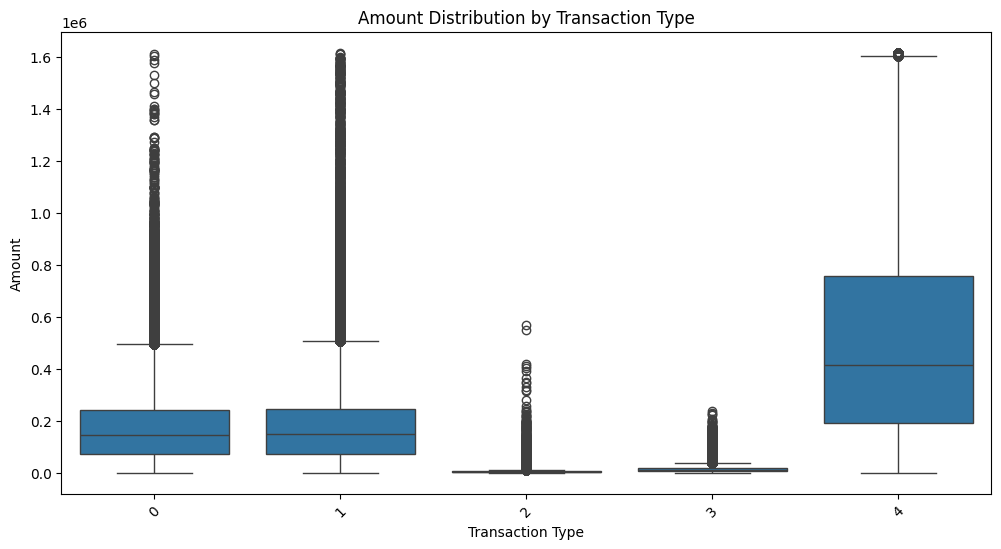

In [ ]:
# Transaction type distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

# Fraud by transaction type
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='isFraud', data=df)
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()

# Amount distribution by transaction type
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='amount', data=df[df['amount'] < df['amount'].quantile(0.99)])
plt.title('Amount Distribution by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

In [62]:
df.drop(columns=['isFlaggedFraud'], inplace=True)

In [63]:
df = pd.get_dummies(df, columns=['type'], drop_first=False)

In [64]:
df['balanceDiffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


In [65]:
df['errorBalanceFlag'] = (
    ((df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0) & (df['amount'] != 0)) |
    ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] != 0))
).astype(int)


In [66]:
import numpy as np
df['log_amount'] = np.log1p(df['amount'])


In [67]:
features = [
    'log_amount',
    'balanceDiffOrig',
    'balanceDiffDest',
    'errorBalanceFlag',
    'type_TRANSFER',
    'type_CASH_OUT'
]
X = df[features]
y = df['isFraud']


In [68]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Handle imbalance
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [69]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [70]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score

y_probs = rf.predict_proba(X_test)[:, 1]

# Threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_threshold = thresholds[f1_scores.argmax()]
y_pred = (y_probs >= best_threshold).astype(int)

print("Best Threshold:", best_threshold)
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))


Best Threshold: 0.9999997010803569
ROC AUC: 0.962809627606895
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.49      0.73      0.58      2464

    accuracy                           1.00   1908786
   macro avg       0.74      0.86      0.79   1908786
weighted avg       1.00      1.00      1.00   1908786

